In [250]:
import pandas as pd
import numpy as np
import cvxopt as opt
import cvxopt.solvers as optsolvers
from matplotlib import pylab
import scipy.stats as sp
import matplotlib.pyplot as plt

In [251]:
data = pd.read_csv('./data/aggregate/sec.csv')

In [252]:
data = data[data['BCH'] != 0]

In [253]:
data.drop(['Time', 'Timestamp'], axis=1, inplace=True)

In [254]:
data.head()

,BCH,BTC,DASH,ETH,LTC,XRP
1922,415.00,2283.06,154.00,184.00,35.11,0.1450
1923,341.00,2373.92,160.00,191.25,36.24,0.1488
1924,240.01,2431.35,159.65,187.10,36.59,0.1473
1925,211.00,2759.23,164.23,214.10,39.15,0.1564
1926,237.00,2734.11,160.66,224.80,38.53,0.1531


In [255]:
log_returns_daily=np.log(data)-np.log(data.shift(1))

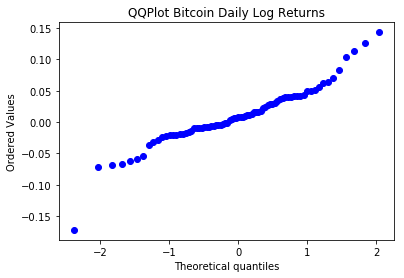

In [256]:
sp.probplot(log_returns_daily.loc[:,'BTC'], dist='norm', fit=True,plot=pylab)
plt.title('QQPlot Bitcoin Daily Log Returns')
pylab.savefig('QQplot.png', bbox_inches='tight')
pylab.show()
plt.show()

In [257]:
log_returns_daily = log_returns_daily.iloc[1:]

In [258]:
Covariance=np.cov(log_returns_daily,rowvar=False)
Returns=np.mean(log_returns_daily,axis=0)

## Minimum Variance Optimization

In [259]:
def optimMV(Covariance):
    Covariance = pd.DataFrame(Covariance)
    n = len(Covariance)
    index = Covariance.index
    Covariance = Covariance.as_matrix()
    P = opt.matrix(Covariance)
    q = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    optsolvers.options['show_progress'] = False
    sol = optsolvers.qp(P, q, A, b)
    #weightsMV = pd.Series(sol['x'], index=Covariance.index)
    weightsMV = pd.Series(sol['x'], index)
    weightsMV/=weightsMV.sum()
    return weightsMV


## Maximize Sharpe Ratio Optimization

In [260]:
def optSR(Log_Returns,Covariance):

    n = len(Covariance)
   
    P = opt.matrix(Covariance)
    q = opt.matrix(0.0, (n, 1))
    G = opt.matrix(np.vstack((-Log_Returns, -np.identity(n))))
    h = opt.matrix(np.vstack((-1.0, np.zeros((n, 1)))))
    sol2 = optsolvers.qp(P, q, G, h)
    weightsSR = pd.Series(sol2['x'])
    weightsSR /= weightsSR.sum()
    return weightsSR



## Risk Parity Optimization

In [261]:
def RiskParity(Covariance):
    Covariance = pd.DataFrame(Covariance)
    weightsRP=np.zeros(len(Covariance))
    for i in range(len(Covariance)):
        weightsRP[i]=1/(Covariance.iloc[i,i])
    weightsRP /= weightsRP.sum()
    return pd.Series(weightsRP)
    

## Minimum Variance Weights

In [262]:
weightsMV=optimMV(Covariance)
print(weightsMV)

0    0.074722
1    0.807714
2    0.115941
3   -0.105635
4   -0.154292
5    0.261550
dtype: float64


In [263]:
weightsRP=RiskParity(Covariance)
print(weightsRP)

0    0.050961
1    0.305538
2    0.144182
3    0.213663
4    0.133256
5    0.152400
dtype: float64


In [264]:
weightsSR=optSR(Returns,Covariance)
print(weightsSR)

0    2.796659e-08
1    9.999980e-01
2    1.317635e-06
3    7.490890e-08
4    5.573159e-08
5    5.455789e-07
dtype: float64
